Вот скрипт, который загружает обученную модель, применяет её к тому же датафрейму и добавляет новую колонку с прогнозами (PREDICTION).

Что делает этот скрипт:  
Загружает данные из базы, как и в обучающем скрипте.  
Кодирует свечи (используется тот же алгоритм CANDLE_CODE).  
Преобразует коды свечей в числовые метки (CANDLE_INT).  
Определяет структуру нейросети, чтобы она совпадала с обученной.  
Загружает веса модели из best_model_02.pth.  
Прогнозирует движение цены (1 – рост, 0 – падение).  
Добавляет колонку PREDICTION в датафрейм.  
Сохраняет результат в predictions.csv.  
Теперь в файле predictions.csv у вас будет таблица с прогнозами. 🚀  

In [2]:
import sqlite3
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
from pathlib import Path

# === 1. ЗАГРУЗКА ДАННЫХ ===
# db_path = Path(r'C:\Users\Alkor\gd\data_quote_db\RTS_futures_options_day.db')

# with sqlite3.connect(db_path) as conn:
#     df_fut = pd.read_sql_query(
#         "SELECT TRADEDATE, OPEN, LOW, HIGH, CLOSE, VOLUME FROM Futures",
#         conn
#     )

db_path = Path(r'C:\Users\Alkor\gd\data_quote_db\MIX_futures_day.db')

with sqlite3.connect(db_path) as conn:
    df_fut = pd.read_sql_query(
        "SELECT TRADEDATE, OPEN, LOW, HIGH, CLOSE, VOLUME FROM Day",
        conn
    )

# === 2. ФУНКЦИЯ КОДИРОВАНИЯ СВЕЧЕЙ (ЛИХОВИДОВ) ===
def encode_candle(row):
    open_, low, high, close = row['OPEN'], row['LOW'], row['HIGH'], row['CLOSE']

    direction = 1 if close > open_ else (0 if close < open_ else 2)
    upper_shadow = high - max(open_, close)
    lower_shadow = min(open_, close) - low
    body = abs(close - open_)

    def classify_shadow(shadow, body):
        return 0 if shadow < 0.1 * body else (1 if shadow < 0.5 * body else 2)

    return f"{direction}{classify_shadow(upper_shadow, body)}{classify_shadow(lower_shadow, body)}"

df_fut['CANDLE_CODE'] = df_fut.apply(encode_candle, axis=1)

# === 3. ПРЕОБРАЗОВАНИЕ КОДОВ В ЧИСЛА ===
unique_codes = sorted(df_fut['CANDLE_CODE'].unique())
code_to_int = {code: i for i, code in enumerate(unique_codes)}
df_fut['CANDLE_INT'] = df_fut['CANDLE_CODE'].map(code_to_int)

window_size = 20  

# === 4. ОПРЕДЕЛЕНИЕ МОДЕЛИ (ДОЛЖНА СОВПАДАТЬ С ОБУЧЕННОЙ) ===
class CandleLSTM(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim):
        super(CandleLSTM, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.embedding(x)
        x, _ = self.lstm(x)
        x = self.fc(x[:, -1, :])
        return self.sigmoid(x)

# === 5. ЗАГРУЗКА ОБУЧЕННОЙ МОДЕЛИ ===
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model_path = "best_model_second.pth"
model = CandleLSTM(
    vocab_size=len(unique_codes), embedding_dim=8, hidden_dim=32, output_dim=1
    ).to(device)
model.load_state_dict(torch.load(model_path, map_location=device))
model.eval()

# === 6. ПРОГНОЗИРОВАНИЕ ===
predictions = []
with torch.no_grad():
    for i in range(len(df_fut) - window_size):
        sequence = torch.tensor(
            df_fut['CANDLE_INT'].iloc[i:i+window_size].values, dtype=torch.long
            ).unsqueeze(0).to(device)
        pred = model(sequence).item()
        predictions.append(1 if pred > 0.5 else 0)

# Заполняем колонку PREDICTION (первые window_size значений - NaN)
df_fut['PREDICTION'] = [None] * window_size + predictions

# === 7. СОХРАНЕНИЕ РЕЗУЛЬТАТОВ ===
predictions_file = r"predictions_second_model.csv"
df_fut.to_csv(predictions_file, index=False)
print(f"✅ Прогнозы сохранены в '{predictions_file}'")


✅ Прогнозы сохранены в 'predictions_second_model.csv'


In [3]:
import pandas as pd
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# === 1. ЗАГРУЗКА РЕЗУЛЬТАТОВ ===
df_fut = pd.read_csv(predictions_file)

# === 2. ДОБАВЛЯЕМ ФАКТИЧЕСКИЙ НАПРАВЛЕНИЕ ЦЕНЫ ===
df_fut['ACTUAL'] = (df_fut['CLOSE'].diff() > 0).astype(int)

# Убираем первые `window_size` значений, где нет прогноза
df_fut = df_fut.dropna(subset=['PREDICTION'])

# Преобразуем в int
df_fut['PREDICTION'] = df_fut['PREDICTION'].astype(int)

# === 3. ОЦЕНКА ТОЧНОСТИ ===
accuracy = accuracy_score(df_fut['ACTUAL'], df_fut['PREDICTION'])
print(f"✅ Точность модели: {accuracy:.2%}")

# === 4. ВЫВОД МАТРИЦЫ ОШИБОК ===
conf_matrix = confusion_matrix(df_fut['ACTUAL'], df_fut['PREDICTION'])
print("\n📊 Матрица ошибок:\n", conf_matrix)

# === 5. ПОДРОБНЫЙ ОТЧЁТ ПО КЛАССАМ ===
report = classification_report(
    df_fut['ACTUAL'], df_fut['PREDICTION'], target_names=["⬇ Падение", "⬆ Рост"]
    )
print("\n📋 Отчет о качестве предсказаний:\n", report)

✅ Точность модели: 53.26%

📊 Матрица ошибок:
 [[ 238  974]
 [ 210 1111]]

📋 Отчет о качестве предсказаний:
               precision    recall  f1-score   support

   ⬇ Падение       0.53      0.20      0.29      1212
      ⬆ Рост       0.53      0.84      0.65      1321

    accuracy                           0.53      2533
   macro avg       0.53      0.52      0.47      2533
weighted avg       0.53      0.53      0.48      2533



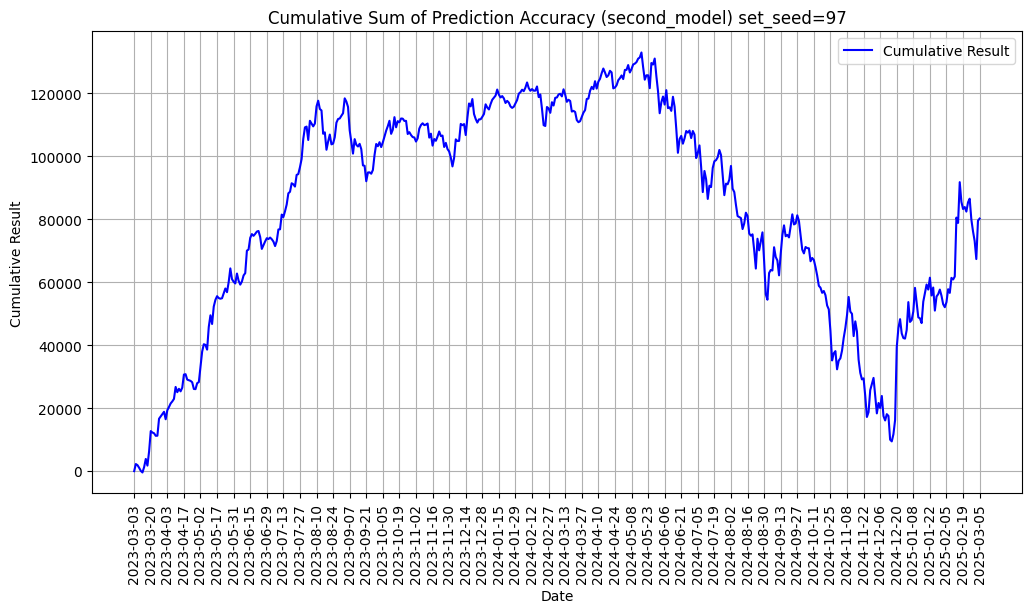

In [4]:
'''
Здесь используется смещение колонки прогноза для сравнения прогноза и факта.
'''
import pandas as pd
import matplotlib.pyplot as plt

# === 1. ЗАГРУЗКА ФАЙЛА И ОТБОР ПОСЛЕДНИХ 20% ===
df = pd.read_csv(predictions_file)

split = int(len(df) * 0.8)  # 80% - обучающая выборка, 20% - тестовая
df = df.iloc[split:].copy()  # Берем последние 20%

# === 2. СМЕЩЕНИЕ ПРОГНОЗА НА ОДИН БАР ВПЕРЁД ===
df["PREDICTION_SHIFTED"] = df["PREDICTION"].shift(1)  # Смещаем вверх

# df

# === 3. РАСЧЁТ РЕЗУЛЬТАТОВ ПРОГНОЗА ===
def calculate_result(row):
    if pd.isna(row["PREDICTION_SHIFTED"]):  # Если NaN после сдвига
        return 0  # Можно удалить или оставить 0

    true_direction = 1 if row["CLOSE"] > row["OPEN"] else 0
    predicted_direction = row["PREDICTION_SHIFTED"]

    difference = abs(row["CLOSE"] - row["OPEN"])
    return difference if true_direction == predicted_direction else -difference

df["RESULT"] = df.apply(calculate_result, axis=1)

# === 4. ПОСТРОЕНИЕ КУМУЛЯТИВНОГО ГРАФИКА ===
df["CUMULATIVE_RESULT"] = df["RESULT"].cumsum()

plt.figure(figsize=(12, 6))
plt.plot(df["TRADEDATE"], df["CUMULATIVE_RESULT"], label="Cumulative Result", color="b")
plt.xlabel("Date")
plt.ylabel("Cumulative Result")
plt.title("Cumulative Sum of Prediction Accuracy (second_model) set_seed=97")
plt.legend()
plt.grid()

# plt.xticks(rotation=45)
plt.xticks(df["TRADEDATE"][::10], rotation=90)
plt.show()

In [5]:
df

,TRADEDATE,OPEN,LOW,HIGH,CLOSE,VOLUME,CANDLE_CODE,CANDLE_INT,PREDICTION,PREDICTION_SHIFTED,RESULT,CUMULATIVE_RESULT
2042,2023-03-03,226025.0,225150.0,228325.0,228300.0,12428,101,10,1.0,NaN,0.0,0.0
2043,2023-03-06,228300.0,228175.0,230825.0,230550.0,14405,110,12,1.0,1.0,2250.0,2250.0
2044,2023-03-07,230525.0,229050.0,230800.0,230175.0,11063,22,8,1.0,1.0,-350.0,1900.0
2045,2023-03-09,230150.0,228225.0,231125.0,229300.0,16155,22,8,1.0,1.0,-850.0,1050.0
2046,2023-03-10,229200.0,226825.0,229750.0,228225.0,12689,22,8,1.0,1.0,-975.0,75.0
...,...,...,...,...,...,...,...,...,...,...,...,...
2548,2025-02-27,332100.0,324325.0,332100.0,328325.0,271316,2,2,1.0,1.0,-3775.0,76200.0
2549,2025-02-28,328000.0,319875.0,328825.0,324900.0,243498,12,5,1.0,1.0,-3100.0,73100.0
2550,2025-03-03,324775.0,316550.0,330300.0,319050.0,334920,21,7,1.0,1.0,-5725.0,67375.0
2551,2025-03-04,318850.0,316700.0,331400.0,331050.0,246511,101,10,1.0,1.0,12200.0,79575.0
